In [1]:
import torch
import torch.nn as nn
from network import *
from train import *
from data2 import get_sdf_data_loader, get_sdf_data_loader_from_sdf_pixels, plot_mesh
import matplotlib.pyplot as plt
import meshio
import numpy as np
import torch.nn.functional as F

# Training

In [2]:
n_objects, n_epoch = 100, 1500
edge_weight = True
step_size, gamma = 200, 0.6
lr_0 = 0.001

In [3]:
edge_weight = True
radius = 0.1
batch_size = 15
data_folder = "data2/dataset_6/graph2/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)

preparing sdf data loader


In [4]:
in_channels, hidden_channels, out_channels = 3, [32, 64, 128, 64, 32], 1
model = UNet_gat_conv(in_channels, hidden_channels, out_channels)

In [5]:
save_name = "gat_" + data_folder.replace("/", "_")

In [6]:
# train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, with_borderless_loss=True, step_size=step_size,
#             gamma=gamma, radius=radius, with_eikonal_loss=False, save_name=save_name, print_every=100)

# Testing

preparing sdf data loader


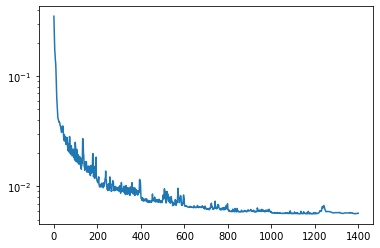

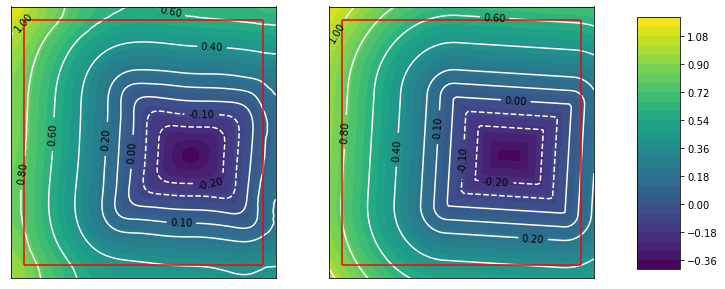

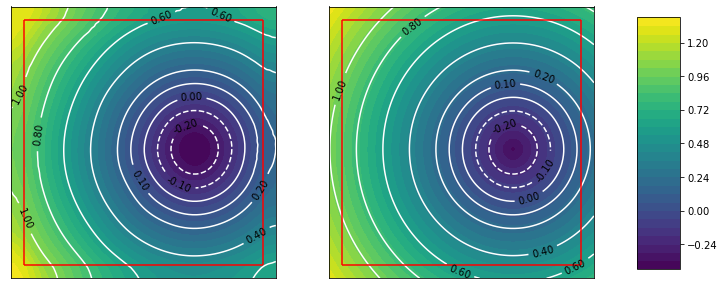

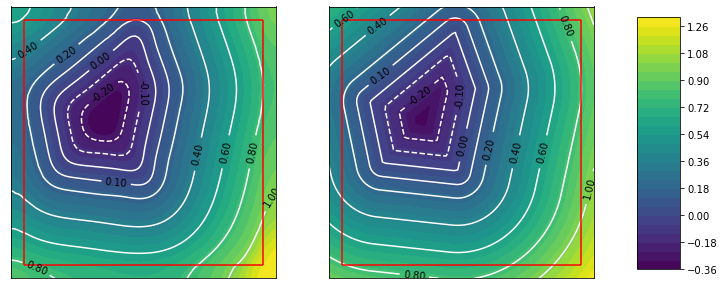

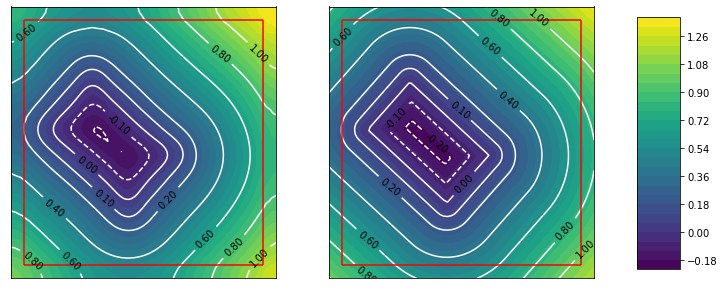

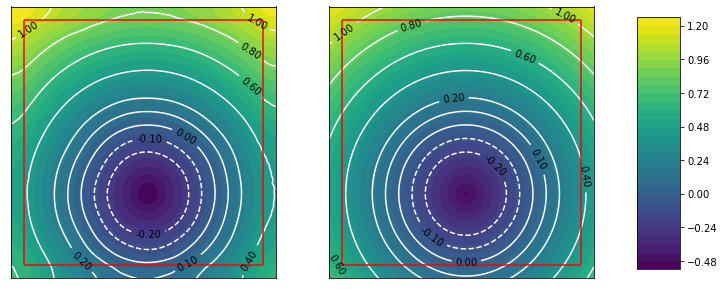

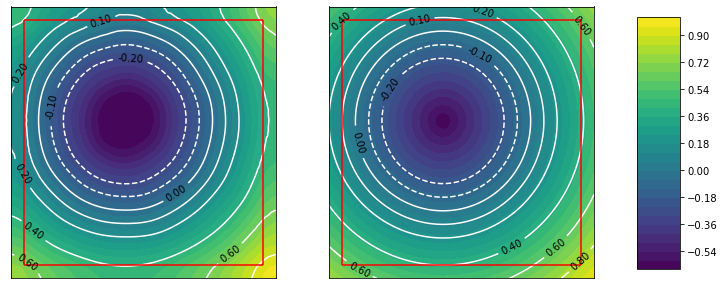

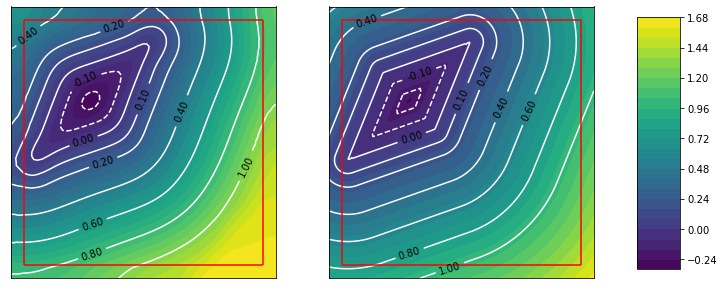

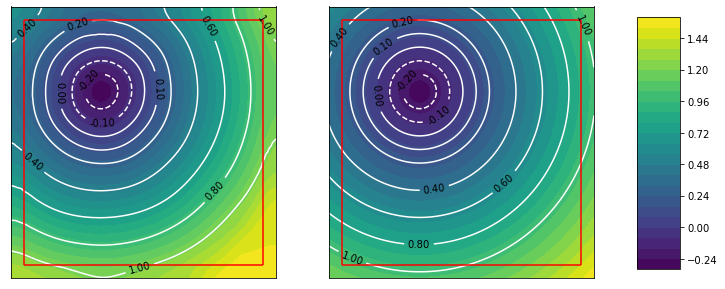

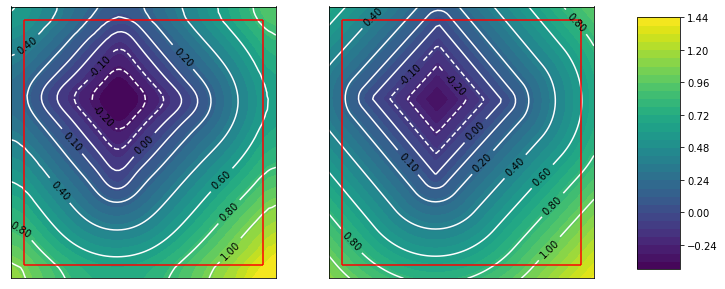

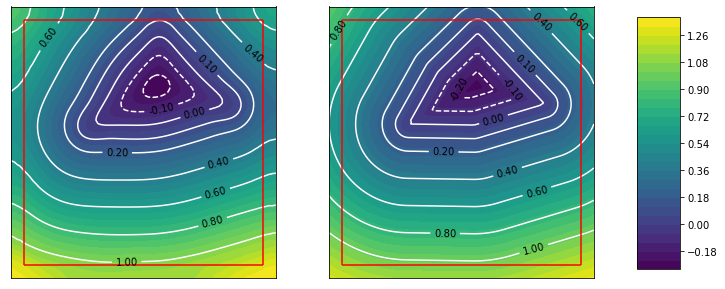

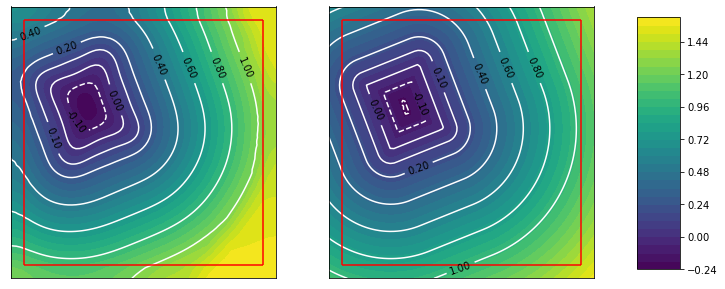

In [29]:
train_data = get_sdf_data_loader(n_objects, data_folder, 1, edge_weight=edge_weight)
plot_results(model, train_data, border=0.1, ndata=10, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.6, 0.8, 1], save_name=save_name)
# plot_results_for_cells(model, train_data, border=0.1, ndata=10, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.6, 0.8, 1], save_name=save_name)

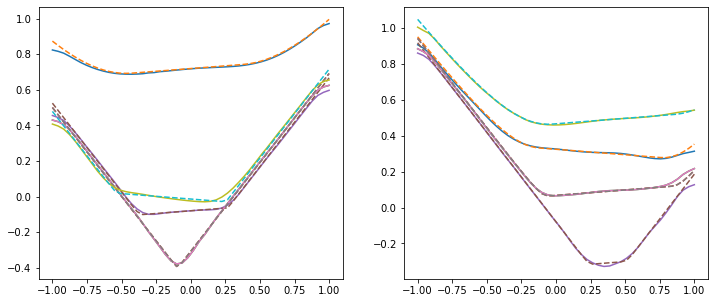

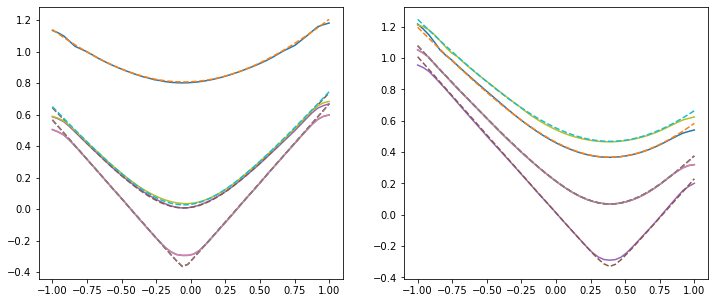

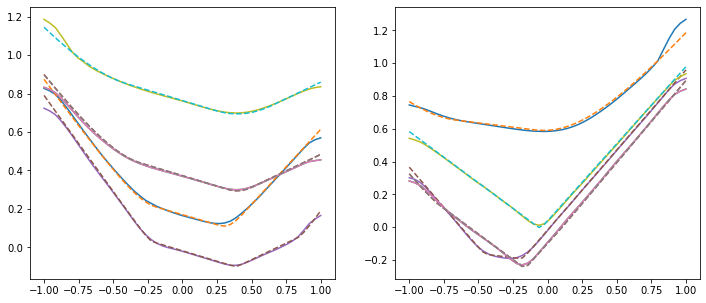

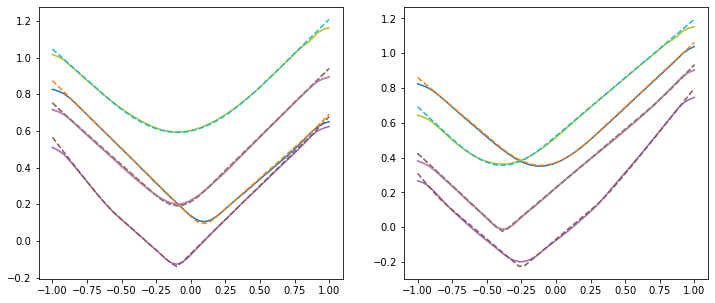

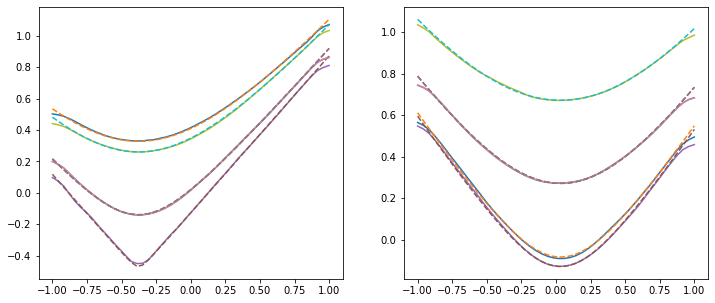

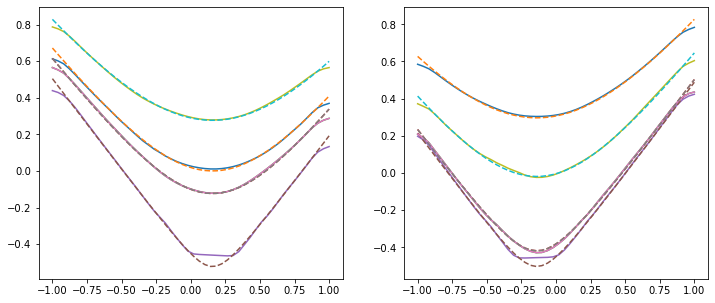

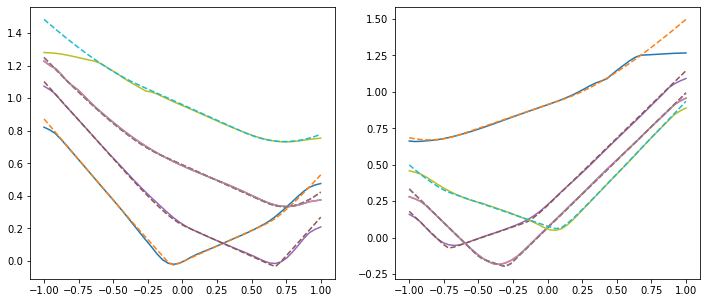

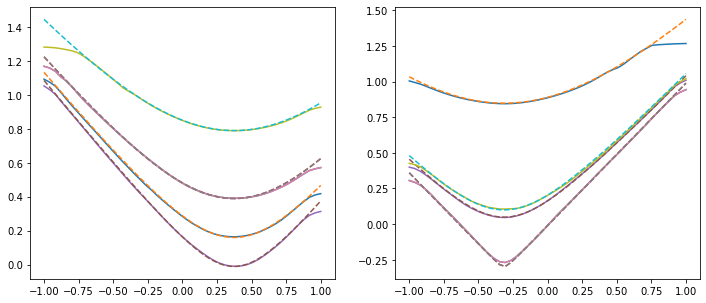

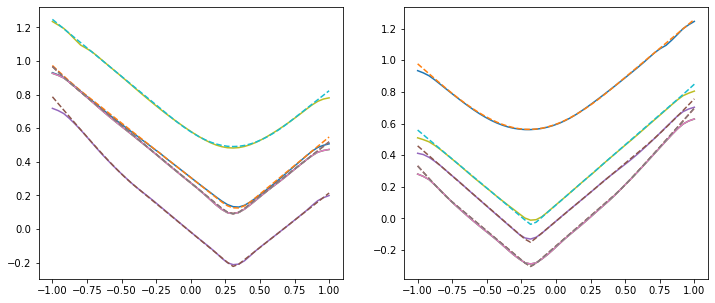

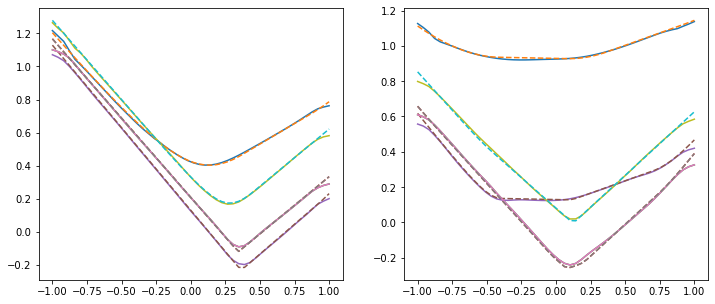

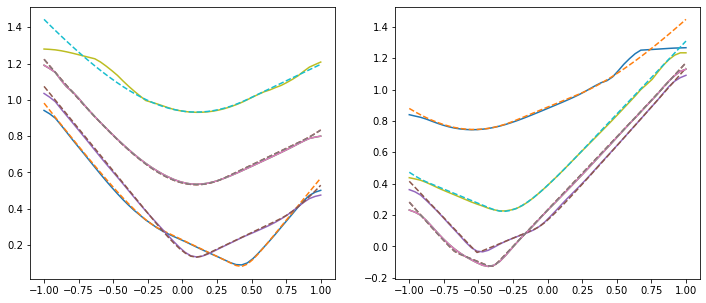

In [8]:
plot_results_over_line(model, train_data, ndata=10, save_name=save_name, lines=[-0.8, 0.4, 0, 0.4, 0.8])

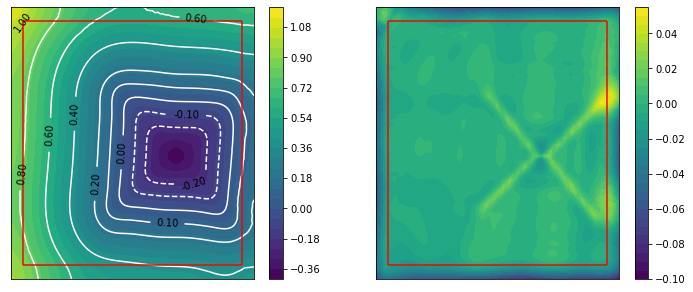

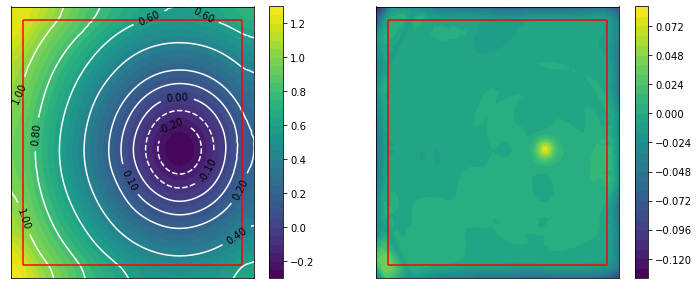

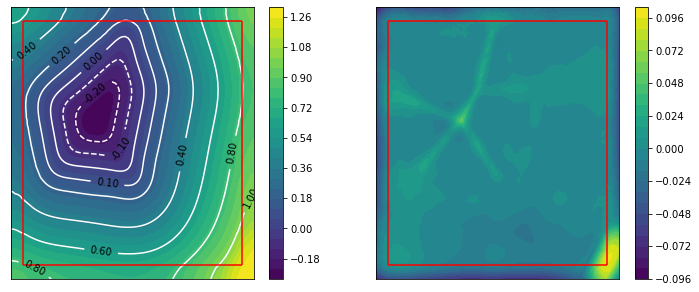

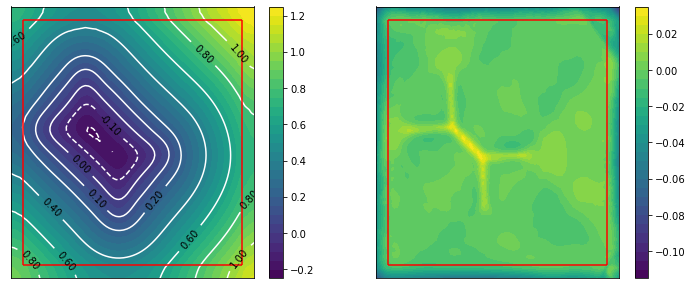

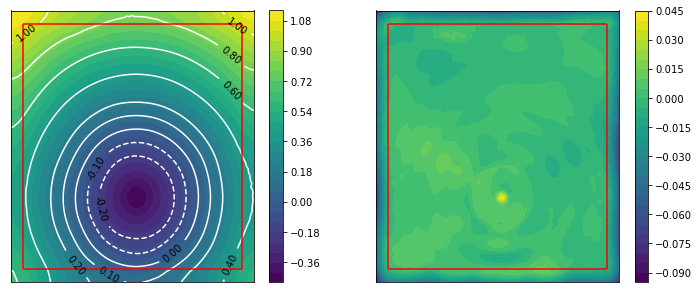

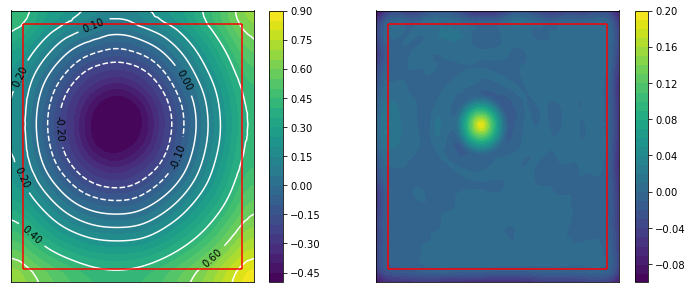

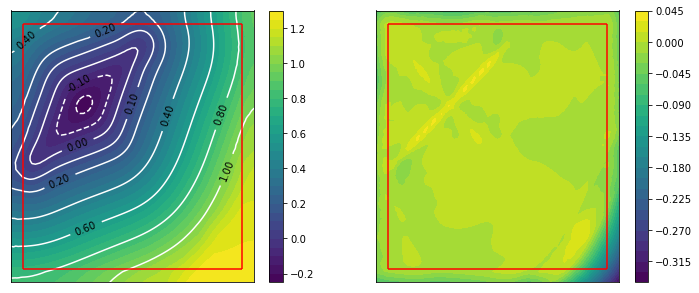

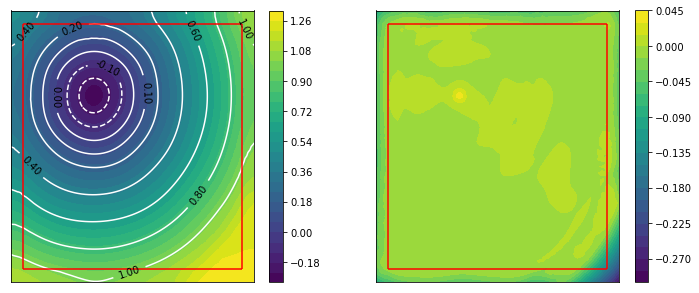

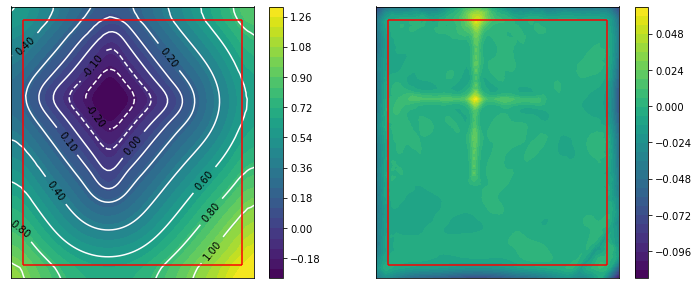

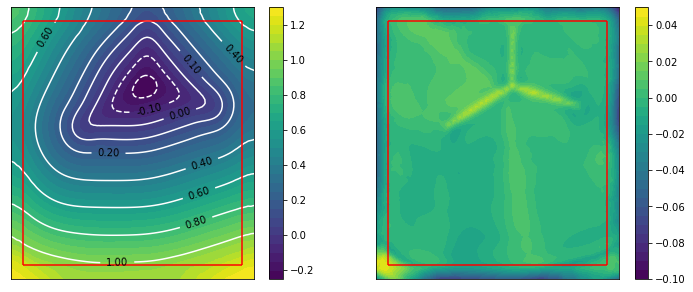

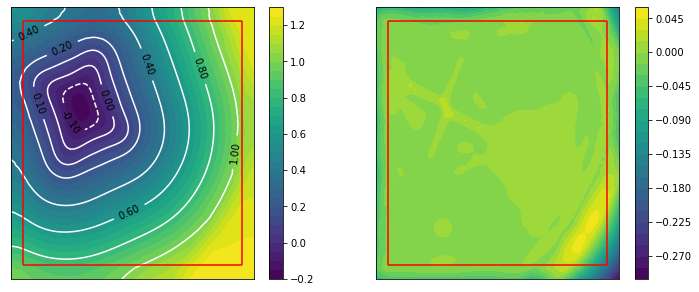

In [9]:
plot_results_diff(model, train_data, border=0.1, ndata=10, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.6, 0.8, 1], save_name=save_name)

# Visualizing $\alpha$ 

In [19]:
device = 'cpu'
model = model.to(device)
model.load_state_dict(torch.load("models/model" + save_name + ".pth", map_location=device))
model.eval()
with torch.no_grad():
    for i, d in enumerate(train_data):
        d = d.to(device=device)
        pred, alphas = model.estimators[0](d.x, d.edge_index, return_attention_weights=True)
        pred2 = model.act(pred)
        pred3, alphas2 = model.estimators[1](pred2, d.edge_index, return_attention_weights=True)
        break
        
cells = d.face.numpy()
points = d.x.numpy()
points[:, 2] = 0.
mesh = meshio.Mesh(points=points, cells=[("triangle", cells.T)])

In [20]:
n_nodes = d.x.shape[0]
n_edges = d.edge_index.shape[1]
edges, alphas = alphas[0].numpy(), alphas[1].numpy()
edges2, alphas2 = alphas2[0].numpy(), alphas2[1].numpy()

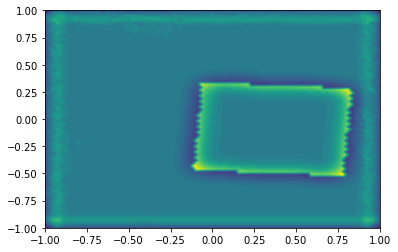

In [21]:
node_attensions = np.zeros(n_nodes)
for i in range(n_edges):
    e1, e2 = edges[:, i]
    w = alphas[i, 0]
    node_attensions[e1] += w
    node_attensions[e2] += w
plot_mesh(mesh, vals=node_attensions)

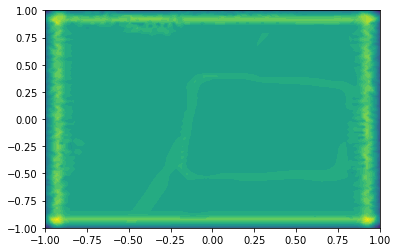

In [22]:
node_attensions = np.zeros(n_nodes)
for i in range(n_edges):
    e1, e2 = edges2[:, i]
    w = alphas2[i, 0]
    node_attensions[e1] += w
    node_attensions[e2] += w
plot_mesh(mesh, vals=node_attensions)

In [24]:
pred.shape

torch.Size([5382, 32])

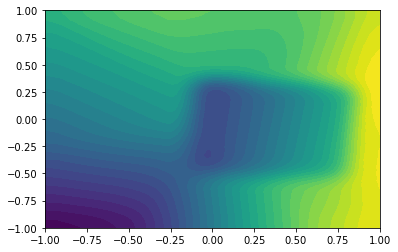

In [35]:
plot_mesh(mesh, vals=pred3[:, 30])

# pxl prediction

In [ ]:
data_folder = "data2/dataset_5/mesh/"
train_data = get_sdf_data_loader_from_sdf_pixels(n_objects, data_folder, 1)

In [ ]:
in_channels, hidden_channels, out_channels = 3, [32, 64, 128, 64, 32], 1
model = UNet_gat_conv(in_channels, hidden_channels, out_channels)

In [ ]:
plot_results_pxl(model, train_data, ndata=5, save_name="gat_data2_dataset_5_mesh_", levels=np.linspace(-0.2, 1., 6))

# analyzing edges

In [ ]:
data_folder = "data2/dataset_5/graph1/"
train_data = get_sdf_data_loader(n_objects, data_folder, 1, edge_weight=edge_weight)
for d in train_data:
    print(d)
    break

In [ ]:
# average number of nodes
len(d.x) ** 0.5

In [ ]:
plt.plot(d.x[:, 0], d.x[:, 1], 'r.')

In [ ]:
from scipy.sparse import coo_matrix
edges = d.edge_index.numpy()
n_edges = edges.shape[1]
n_nodes = d.x.shape[0]

In [ ]:
ee = coo_matrix((np.ones(n_edges), (edges[0, :], edges[1, :])), shape=(n_nodes, n_nodes))

In [ ]:
plt.hist(np.sum(ee, axis=0).tolist()[0])

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(d.x[:, 0], d.x[:, 1], 'r.')
plt.gca().axis('equal')
circle1 = plt.Circle((d.x[1150,0], d.x[1150,1]), 0.06, color='k')
plt.gca().add_artist(circle1)

In [ ]:
model.estimators